In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 9

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/27 [>.............................] - ETA: 5s - loss: 1.9990 - accuracy: 0.1250
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 5ms/step - loss: 1.8803 - accuracy: 0.2151 - val_loss: 1.7470 - val_accuracy: 0.3457
Epoch 2/1000
 1/27 [>.............................] - ETA: 0s - loss: 1.7130 - accuracy: 0.3047
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 1.6774 - accuracy: 0.3342 - val_loss: 1.5964 - val_accuracy: 0.3492
Epoch 3/1000
 1/27 [>.............................] - ETA: 0s - loss: 1.5616 - accuracy: 0.3594
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 1.5082 - accuracy: 0.3507 - val_loss: 1.4058 - val_accuracy: 0.3616
Epoch 4/1000
 1/27 [>.............................] - ETA: 0s - loss: 1.4332 - accuracy: 0.3203
E

 1/27 [>.............................] - ETA: 0s - loss: 0.6821 - accuracy: 0.7031
Epoch 28: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.7062 - accuracy: 0.7143 - val_loss: 0.4721 - val_accuracy: 0.9012
Epoch 29/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.6209 - accuracy: 0.7500
Epoch 29: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.7163 - accuracy: 0.7158 - val_loss: 0.4654 - val_accuracy: 0.9021
Epoch 30/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.8290 - accuracy: 0.6562
Epoch 30: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.7006 - accuracy: 0.7234 - val_loss: 0.4639 - val_accuracy: 0.9021
Epoch 31/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.6705 - accuracy: 0.7422
Epoch 31

 1/27 [>.............................] - ETA: 0s - loss: 0.6118 - accuracy: 0.7578
Epoch 55: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.5647 - accuracy: 0.7852 - val_loss: 0.3220 - val_accuracy: 0.9339
Epoch 56/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.5717 - accuracy: 0.7891
Epoch 56: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.5625 - accuracy: 0.7905 - val_loss: 0.3208 - val_accuracy: 0.9259
Epoch 57/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.5077 - accuracy: 0.7969
Epoch 57: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.5809 - accuracy: 0.7799 - val_loss: 0.3226 - val_accuracy: 0.9233
Epoch 58/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.6657 - accuracy: 0.7578
Epoch 58

 1/27 [>.............................] - ETA: 0s - loss: 0.5290 - accuracy: 0.8047
Epoch 82: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.5115 - accuracy: 0.8076 - val_loss: 0.2752 - val_accuracy: 0.9259
Epoch 83/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.5102 - accuracy: 0.8047
Epoch 83: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4946 - accuracy: 0.8144 - val_loss: 0.2641 - val_accuracy: 0.9330
Epoch 84/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.5401 - accuracy: 0.8047
Epoch 84: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.5282 - accuracy: 0.8017 - val_loss: 0.2676 - val_accuracy: 0.9330
Epoch 85/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4283 - accuracy: 0.8359
Epoch 85

 1/27 [>.............................] - ETA: 0s - loss: 0.5345 - accuracy: 0.7891
Epoch 109: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4845 - accuracy: 0.8211 - val_loss: 0.2568 - val_accuracy: 0.9268
Epoch 110/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.6057 - accuracy: 0.7891
Epoch 110: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4700 - accuracy: 0.8358 - val_loss: 0.2634 - val_accuracy: 0.9259
Epoch 111/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.6003 - accuracy: 0.7969
Epoch 111: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.8167 - val_loss: 0.2494 - val_accuracy: 0.9277
Epoch 112/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4897 - accuracy: 0.8594
Ep

Epoch 136/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4691 - accuracy: 0.8281
Epoch 136: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4841 - accuracy: 0.8214 - val_loss: 0.2381 - val_accuracy: 0.9347
Epoch 137/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4790 - accuracy: 0.7969
Epoch 137: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4701 - accuracy: 0.8252 - val_loss: 0.2350 - val_accuracy: 0.9347
Epoch 138/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4943 - accuracy: 0.8281
Epoch 138: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4681 - accuracy: 0.8258 - val_loss: 0.2302 - val_accuracy: 0.9409
Epoch 139/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4792 - accu

Epoch 163/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4212 - accuracy: 0.8281
Epoch 163: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4357 - accuracy: 0.8361 - val_loss: 0.2320 - val_accuracy: 0.9321
Epoch 164/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4503 - accuracy: 0.8359
Epoch 164: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4590 - accuracy: 0.8285 - val_loss: 0.2340 - val_accuracy: 0.9303
Epoch 165/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4025 - accuracy: 0.8281
Epoch 165: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4541 - accuracy: 0.8294 - val_loss: 0.2366 - val_accuracy: 0.9268
Epoch 166/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.3712 - accu

Epoch 190/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4650 - accuracy: 0.8125
Epoch 190: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4518 - accuracy: 0.8335 - val_loss: 0.2329 - val_accuracy: 0.9295
Epoch 191/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.5798 - accuracy: 0.8047
Epoch 191: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.8261 - val_loss: 0.2293 - val_accuracy: 0.9286
Epoch 192/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.3590 - accuracy: 0.8672
Epoch 192: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4433 - accuracy: 0.8382 - val_loss: 0.2246 - val_accuracy: 0.9356
Epoch 193/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.3619 - accu

Epoch 217/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.5148 - accuracy: 0.7891
Epoch 217: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4494 - accuracy: 0.8379 - val_loss: 0.2319 - val_accuracy: 0.9295
Epoch 218/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.3319 - accuracy: 0.8750
Epoch 218: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4470 - accuracy: 0.8388 - val_loss: 0.2167 - val_accuracy: 0.9347
Epoch 219/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.3693 - accuracy: 0.8906
Epoch 219: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.4438 - accuracy: 0.8411 - val_loss: 0.2166 - val_accuracy: 0.9392
Epoch 220/1000
 1/27 [>.............................] - ETA: 0s - loss: 0.4603 - accu

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

9/9 [==============================] - 0s 625us/step - loss: 0.2298 - accuracy: 0.9303


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.6239722e-01 5.7653926e-02 7.7752680e-01 2.3438255e-03 4.5430435e-05
 3.2841115e-05]
2


# 混同行列

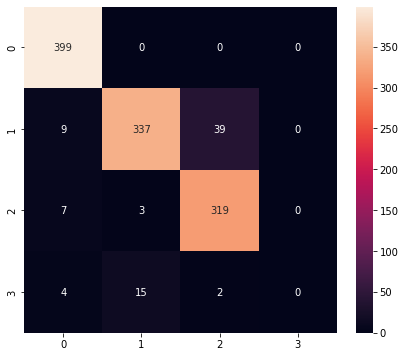

Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       399
           1       0.95      0.88      0.91       385
           2       0.89      0.97      0.93       329
           3       0.00      0.00      0.00        21

    accuracy                           0.93      1134
   macro avg       0.70      0.71      0.70      1134
weighted avg       0.91      0.93      0.92      1134



c:\users\xia0d\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\xia0d\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\xia0d\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Xia0D\AppData\Local\Temp\tmpu9o7ku92\assets


6496

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.6239725e-01 5.7653923e-02 7.7752680e-01 2.3438255e-03 4.5430435e-05
 3.2841115e-05]
2
